<a href="https://colab.research.google.com/github/AnshMittal1811/BasicCVprogs/blob/master/DisplayingNumbers_using_Pytesseract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install ipython-autotime
%load_ext autotime

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd 'drive/My Drive/Data/DisplayNumbers'

/content/drive/My Drive/Data/DisplayNumbers
time: 6.39 ms


In [3]:
ls

 English/                                          Img1.png  'kaggle (1).json'
 english-typed-alphabets-and-numbers-dataset.zip   Img2.jpg  'kaggle (2).json'
 Img1.jpg                                          Img2.png   kaggle.json
time: 2.89 s


#### Requirements: 
1.   Identify the text and numbers written in these two images.
2.   Draw a box around the text being read, identify and print the text.
3.   Given that the image quality is blur, use appropriate image preprocessing techniques to enhance the readibility of text.



## Importing and downloading all libraries

In [4]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
time: 6.4 s


In [5]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import imutils
from scipy import ndimage
import glob
import pytesseract
import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image
from pytesseract import Output

file_path  = './'
images = glob.glob('*.png')
print(images)

['Img2.png', 'Img1.png']
time: 58.7 ms


# Functions to perform Text detection

## Defining functions for Skew Correction
These functions are used for Ordering points and 4-point transform for Skew correction for Optical Caracter Recognition application. 

In [6]:
def order_points(pts):

  # initialzie a list of coordinates that will be ordered
  # such that the first entry in the list is the top-left,
  # the second entry is the top-right, the third is the
  # bottom-right, and the fourth is the bottom-left
  rect = np.zeros((4, 2), dtype="float32")
  
  # the top-left point will have the smallest sum, whereas
  # the bottom-right point will have the largest sum
  s = pts.sum(axis=1)
  rect[0] = pts[np.argmin(s)]
  rect[2] = pts[np.argmax(s)]
  
  # now, compute the difference between the points, the
  # top-right point will have the smallest difference,
  # whereas the bottom-left will have the largest difference
  diff = np.diff(pts, axis=1)
  rect[1] = pts[np.argmin(diff)]
  rect[3] = pts[np.argmax(diff)]
  
  # return the ordered coordinates
  return rect


time: 7.04 ms


In [7]:
def four_point_transform(image, pts):  
  # obtain a consistent order of the points and unpack them
  # individually
  rect = order_points(pts)
  (tl, tr, br, bl) = rect
  
  # compute the width of the new image, which will be the
  # maximum distance between bottom-right and bottom-left
  # x-coordiates or the top-right and top-left x-coordinates
  widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
  widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
  maxWidth = max(int(widthA), int(widthB))
  
  # compute the height of the new image, which will be the
  # maximum distance between the top-right and bottom-right
  # y-coordinates or the top-left and bottom-left y-coordinates
  heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
  heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
  maxHeight = max(int(heightA), int(heightB))
  
  # now that we have the dimensions of the new image, construct
  # the set of destination points to obtain a "birds eye view",
  # (i.e. top-down view) of the image, again specifying points
  # in the top-left, top-right, bottom-right, and bottom-left
  # order
  dst = np.array([
      [0, 0],
      [maxWidth - 1, 0],
      [maxWidth - 1, maxHeight - 1],
      [0, maxHeight - 1]], dtype="float32")
  
  # compute the perspective transform matrix and then apply it
  M = cv.getPerspectiveTransform(rect, dst)
  warped = cv.warpPerspective(image, M, (maxWidth, maxHeight))
  return warped


time: 18.4 ms


## Defining basic functions 

The functions are used for detecing boxes, sharpening images, rotating images, finding Canny edges, and resizing images.

In [8]:
def detect_box(img, cnts):
  rect = cv.minAreaRect(cnts)
  box = cv.boxPoints(rect)
  box = np.int0(box)
  return box

def sharpen_img(img): 
  kernel = np.array([[-1,-1,-1], 
                      [-1,9,-1], 
                      [-1,-1,-1]])

  img = cv.filter2D(img, -1, kernel)
  return img

def rotate_img(img): 
  '''
  Rotating the image
  '''
  rot_img = cv.rotate(img, cv.ROTATE_90_COUNTERCLOCKWISE)
  return rot_img


def find_Canny(img, kernel, std_dev, f_thresh, s_thresh):
  '''
  Finding Canny edges in images
  '''
  k = kernel
  gb = cv.GaussianBlur(img, (k, k), std_dev)
  edged = cv.Canny(gb, f_thresh, s_thresh)
  return edged

def resize_image(img, scale_percent):
  '''
  Resizes the images according to the scale
  '''
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  # dimensions
  dsize = (width, height)

  # resize image
  resized = cv.resize(img, dsize)
  return resized

def display_img(img): 
  cv2_imshow(img)
  print('-'*50)

time: 20.3 ms


## Defining complex functions 

The functions are used for finding contours (for single text and multiple texts) and creating automated boxes. Then pytesseract is used for detecting the text in the detected boxes. 

In [18]:
def find_contours(img, status):
  '''
  Finds the contours for the images
  '''
  status_1 = status + 1
  status_2 = status + 2
  # finding the contours for the bounding box
  (contours, heirarchy) = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  cnts = np.concatenate((contours[status_1], contours[status_2]), axis = 0)
  return cnts

def find_contours_s(img, status):
  '''
  Finds the contours for a single line text in the images
  '''
  status_46 = status + 46
  status_79 = status + 79
  # finding the contours for the bounding box
  (contours, heirarchy) = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  cnts = np.concatenate((contours[status_46], contours[status_79]), axis = 0)
  return cnts



def create_clean_semiauto_box(img, pts, xlen, ylen, value1, 
                               value2, value3, value4, cnt):
  '''
  to create a clean semi-automated box
  '''

  for i in range(xlen):
    for j in range(ylen):
      val = pts[i][j]
      if val == value1 or val == value3:
        pts[i][j] = val - 7
      elif val == value2 or val == value4:
        pts[i][j] = val + 10

  boxed = cv.drawContours(img, [pts], -1, (0,255,0), 1)
  display_img(boxed)
  img1 = img[pts[1][1]:pts[3][1], pts[1][0]:pts[3][0]]
  text = pytesseract.image_to_string(img1)
  final = cv.putText(img, str(cnt), (pts[1][0], pts[1][1]), cv.FONT_HERSHEY_COMPLEX_SMALL, 1,(0,0,255), 1)
  return text, final


def create_automated_boxes_multiple(img, f, l):
  '''
  Creating multiple bounding boxes for the image
  '''
  # Getting the coordinates for the bounding boxes
  d = pytesseract.image_to_data(img, output_type=Output.DICT)
  n_boxes = len(d['level']) - f
  a = []
  cnt = 0
  m = len(a)

  for i in range(n_boxes):
    # counter to remove repition
    s = 0
    # Automatically creating bounding boxes
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    img1 = cv.rectangle(img, (x-l, y-l), (x + w, y + h), (0, 255, 0), 1)
    # Try to recognize strings of characters using automatically created boxes
    b = pytesseract.image_to_string(img1[y:y + h, x:x + w])
    # Replacing character which may be easity mistaken
    b = b.replace('$', '5').replace('¥','Y').replace(')','1')
    
    for j in range(len(a)):
      if (b == '' or b == ' ' or b == a[j]): 
        s = 1
        break
    if s == 1:
      continue
    a.append(b)
    img2 = cv.putText(img1, str(cnt), (x - i, y - i), cv.FONT_HERSHEY_COMPLEX_SMALL, 1,(0,0,255), 1)
    cnt = cnt + 1
  return a[m], img2

time: 76.2 ms


In [19]:
def preprocessing(img, status, first_thresh, 
                  second_thresh, stddev, resize, rotate_counter, 
                  skew_counter,kernels = 3):
  '''
  This function is used for Rotation of Image if its not rotated correctly. 
  It is also used for skew correction using contours and resizing the images 
  '''
  val1 = 377
  val2 = 122
  val3 = 4
  if rotate_counter == 1:

    # Rotating the image
    img1 = rotate_img(img)
    # gray scale picture
    gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    # image sharpened and stored in another variable
    img2 = sharpen_img(img1)
    # take canny edges for the grayscaled image
    edged = find_Canny(gray,kernels,stddev,first_thresh,second_thresh)
    # Find the contours and save in another variable
    cnts = find_contours(edged,status**2)

  else: 

    # image sharpened and stored in another variable
    img1 = sharpen_img(im)
    # gray scale picture
    gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    # take canny edges for the grayscaled image
    edged = find_Canny(gray,kernels,stddev, first_thresh, second_thresh)
    # Find only one contour for single line text
    cnts = find_contours_s(edged,status**2)

  # Box the skewed image
  boxing = detect_box(img1, cnts)
  pts = np.array(boxing.reshape(4, 2))

  if skew_counter == 0:
    text, final = create_clean_semiauto_box(img1, pts, pts.shape[0], 
                                             pts.shape[1], val1, val1 + 207, 
                                             val2, val2 + 18,rotate_counter+1)
  else:

    boxed = cv.drawContours(img1, [boxing], -1, (0,255,0), 0)
    # Display boxes with the rotated image
    display_img(boxed)
    # Here, the deskewing occurs and is basically the step which is different for the if statement
    # Transforming the image using four point transform
    warped = four_point_transform(img2, pts)
    # Resize the image
    img3 = resize_image(warped, resize)
    # Creating Boxes Using Pytesseract
    text, final = create_automated_boxes_multiple(img3, val3, val3-1)

  return text, final

time: 24.7 ms


# Main Function

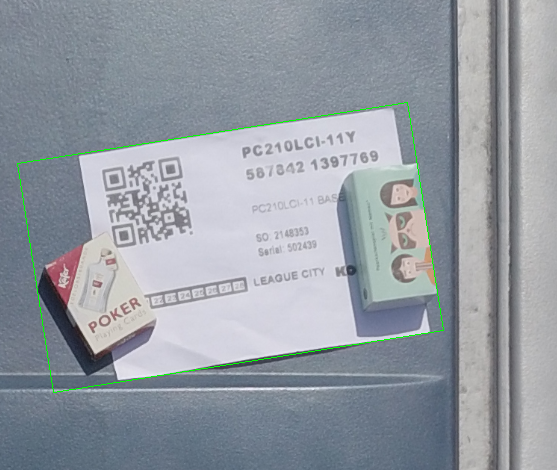

--------------------------------------------------
Detected Text: 


PC210LCI-11Y
587842 1397769

PC210LC1-11 BAS,

SO, 2148353
Serial: 502439

RQ Latest] LEAGUE CITY yy
--------------------------------------------------


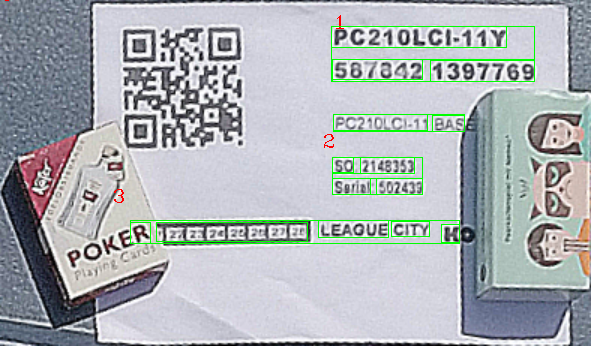

--------------------------------------------------


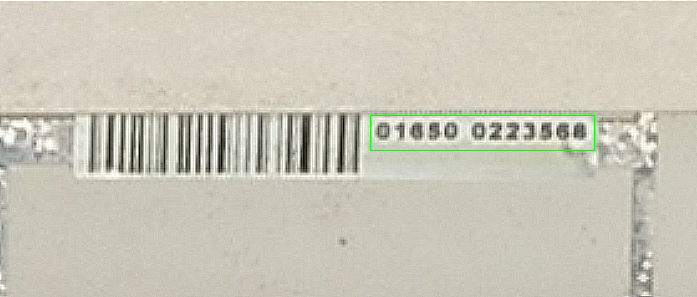

--------------------------------------------------
Detected Text: 


01650 0273568
--------------------------------------------------


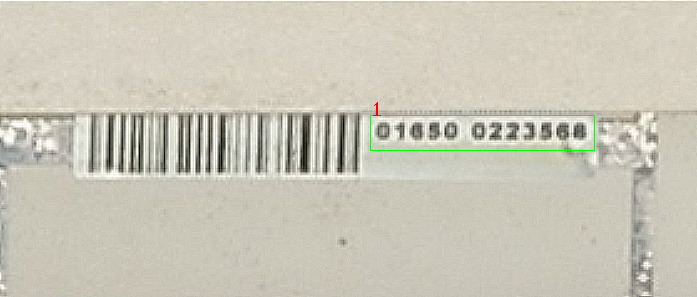

--------------------------------------------------
time: 6.23 s


In [21]:
def main():
  for i in range(len(images)):
    
    im = cv.imread(images[i])
    if images[i] == 'Img2.png':
      text, final = preprocessing(img = im, status = 10,
                        first_thresh = 127,
                        second_thresh = 250, stddev = 100,
                        resize = 150, rotate_counter = 1, 
                        skew_counter = 1)
 
    else: 
      text, final = preprocessing(img = im, status = 10,
                        first_thresh = 200,
                        second_thresh = 255, stddev = 0.0000005,
                        resize = 100, rotate_counter = 0, 
                        skew_counter = 0, kernels = 7)
    
    print('Detected Text: \n\n\n' + text)
    print('-'*50)
    display_img(final)

if __name__=="__main__":
  main()
  

----------